# Plot spider


In [6]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

from local_python.local_utils import load_pd_from_json, load_datasets_and_aggregate
from local_python.radar_chart import radar_factory

In [4]:
metric_file_root_path = "../runs/"

dataset_configs = {
    # "PlantDoc-ResNet50": "PlantDoc", #
    # "PAD_UFES_20-ResNet50": "PAD-UFES-20", #
    # "DDI-ResNet50": "DDI", #
    # "HAM10000-ResNet50": "HAM10000", #
    # "Fitzpatrick17k-ResNet50": "Fitzpatrick17k", #
    # "Cassava-ResNet50": "Cassava", #
    # "PlantVillage-ResNet50": "PlantVillage", #
    # "PlantDataset-ResNet50": "PlantDataset", #
    "PlantDoc-ViT_T16-student": "PlantDoc",  #
    "PAD_UFES_20-ViT_T16-student": "PAD-UFES-20",  #
    "DDI-ViT_T16-student": "DDI",  #
    "HAM10000-ViT_T16-student": "HAM10000",  #
    "Fitzpatrick17k-ViT_T16-student": "Fitzpatrick17k",  #
    "Cassava-ViT_T16-student": "Cassava",  #
    "PlantVillage-ViT_T16-student": "PlantVillage",  #
    "PlantDataset-ViT_T16-student": "PlantDataset",  #
}

selection_config = {
    "model_name": "lr",
    # "model_name": "knn",
    "number_of_samples": "All",
    "feature_identifier": [
        "-Plant",
        "-Derma",
        "-ImageNet_1k_SSL",
        # "-PDDD",
        # "-Derma",
        # "-ImageNet_1k_SL_V1",
        # "-ImageNet_1k_SSL_SimCLR",
    ],  # also used as order
    "f1_macro": None,
}

# title = f"Logistic regression"
title = f"KNN"
labels = ["SSL Plant", "SSL Derma", "SSL ImageNet"]
# labels = ["SL Plant", "SSL Derma", "SL ImageNet", "SSL ImageNet"]

In [11]:
def number_to_string(value):
    if value == value:
        return str(int(value))
    else:  # NaN
        return "All"

def load_datasets_and_aggregate(dataset_configs, selection_config):
    data = []
    for column, dataset_key in enumerate(dataset_configs):
        target_columns = [k for k, v in selection_config.items() if v is None]
        assert 1 == len(
            target_columns
        ), f"Invalid configuration. Exactly 1 key should have (None) as value, but there are {len(target_columns)}"
        dataset_label = dataset_configs[dataset_key]
        metric_file_path = os.path.join(
            metric_file_root_path, f"{dataset_key}-metrics.txt"
        )
        df_full = load_pd_from_json(metric_file_path)
        df_full["number_of_samples"] = df_full["number_of_samples"].apply(
            number_to_string
        )
        selected_values = select_and_sort_dataframe(df_full.copy(), selection_config)[
            target_columns
        ].values
        if len(labels) != len(selected_values):
            print(df_full["feature_identifier"].unique())
            print(labels)
            # assert False, f"Number of values do not match {len(labels)} != {len(selected_values)}"
        else:
            data.append(selected_values)
    df_agg = pd.DataFrame(
        np.transpose(data).squeeze(), columns=dataset_configs.values()
    )
    df_agg.index = labels
    return df_agg

In [12]:
df_plot = load_datasets_and_aggregate(dataset_configs, selection_config)
df_plot

Read 4812 entries from PlantDoc-ViT_T16-student-metrics.txt
Read 4812 entries from PAD_UFES_20-ViT_T16-student-metrics.txt
Read 6012 entries from DDI-ViT_T16-student-metrics.txt
Read 6012 entries from HAM10000-ViT_T16-student-metrics.txt
Read 6012 entries from Fitzpatrick17k-ViT_T16-student-metrics.txt
Read 6012 entries from Cassava-ViT_T16-student-metrics.txt
Read 6012 entries from PlantVillage-ViT_T16-student-metrics.txt
Read 4812 entries from PlantDataset-ViT_T16-student-metrics.txt


,PlantDoc,PAD-UFES-20,DDI,HAM10000,Fitzpatrick17k,Cassava,PlantVillage,PlantDataset
SSL Plant,0.527050,0.507790,0.630633,0.628743,0.590696,0.636879,0.994168,0.863815
SSL Derma,0.316969,0.471365,0.564226,0.629933,0.588436,0.539037,0.978944,0.809258
SSL ImageNet,0.507791,0.589525,0.605690,0.616255,0.597080,0.649028,0.981642,0.934652


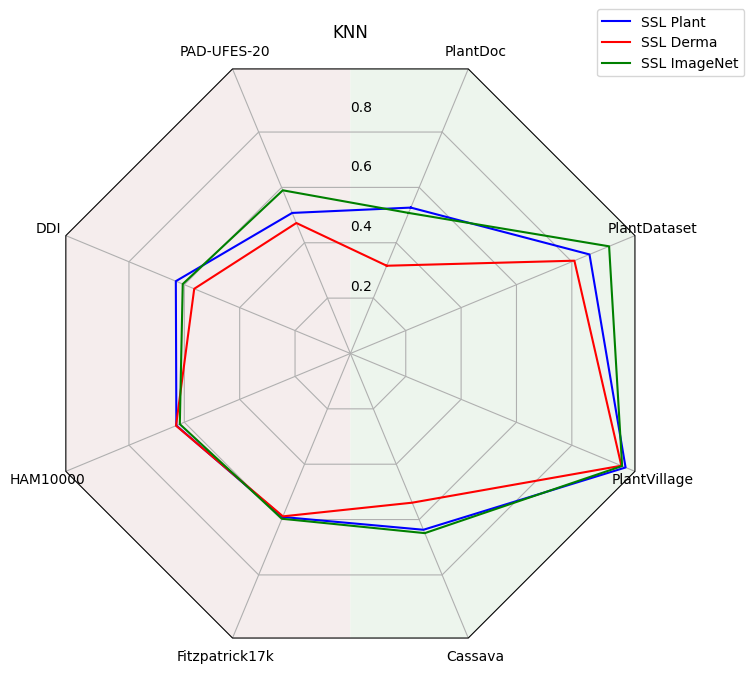

In [5]:
colors = ["b", "r", "g", "m", "y"]

number_of_categories = len(df_plot.columns)
rotation_offset=np.pi/2-np.pi/number_of_categories
theta = radar_factory(number_of_categories, frame="polygon", rotation_offset=rotation_offset)

fig, axes = plt.subplots(
    figsize=(8, 8),
    nrows=1,
    ncols=1,
    subplot_kw=dict(projection="radar"),
    squeeze=False,
)

ax = axes.flat[0]
for i, (index, row) in enumerate(df_plot.iterrows()):
    color = colors[i] if i < len(colors) else None
    ax.set_theta_offset(rotation_offset)
    ax.plot(theta, row.values, color=color, label=index)
    # ax.fill(theta, row.values, facecolor=color, alpha=0.15) # , label="_nolegend_"

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title(title)
ax.set_varlabels(df_plot.columns)
# ax.legend(df_plot.index.values, loc=(0.9, 0.95), labelspacing=0.1, fontsize="small")
north = np.pi/2-rotation_offset
ax.axvspan(north, np.pi+north, facecolor=(0.95, 0.9, 0.9), alpha=0.7) # red
ax.axvspan(np.pi+north, 2*np.pi+north, facecolor=(0.9, 0.95, 0.9), alpha=0.7) # green
plt.legend(loc=(0.9, 0.95))